In [109]:
import pandas as pd 

bib = open('data/anthology+abstracts.bib', 'r')
lines = bib.readlines()
records = []
for l in lines:
    l = l.lstrip(' ')
    if 'proceedings{' in l or 'article{' in l:
        recs = {}
    elif l == '}\n':
        for key in ['title', 'abstract', 'year', 'booktitle']:
            if key not in recs.keys():
                recs[key] = np.nan
        records.append(recs)
    else:
        for key in ['title', 'abstract', 'year', 'booktitle']:
            if l.startswith(f'{key}'):
                recs[key] = l.lstrip(rf'{key} = ').rstrip(',\n').rstrip('"').lstrip('"')

In [132]:
import pandas as pd
import numpy as np
df = pd.DataFrame(records)
df.to_json('acl.jsonl', orient='records', lines=True)
df = df.dropna(subset=['year', 'booktitle'], axis=0)
df['year'] = df['year'].astype(int)

In [141]:
df['is_transformer_title'] = np.where((df['title'].str.lower().str.contains('transformer.*', regex=True)) | 
                                      (df['title'].str.lower().str.contains('self\-attention', regex=True)) | 
                                      (df['title'].str.lower().str.contains('large language models', regex=True)),1,0)
df['is_transformer_abstract'] = np.where((df['abstract'].str.lower().str.contains('transformer.*', regex=True))| 
                                         (df['abstract'].str.lower().str.contains('self\-attention', regex=True)) | 
                                         (df['abstract'].str.lower().str.contains('large language models', regex=True)),1,0)

In [142]:
df = df.dropna(axis=0, subset=['title', 'abstract'])

In [143]:
grouped = df.groupby('year').count().reset_index()[['year','title']].rename({'title': 'count'}, axis=1)
prop_title = df.groupby(['year','is_transformer_title']).count().reset_index()[['year', 
                                                                                'title', 
                                                                                'is_transformer_title']].merge(grouped, how='outer').rename({'title': 'prop'}, axis=1)
prop_title['is_transformer_title_prop'] = prop_title['prop'] / prop_title['count']

In [153]:
prop_abstract = df.groupby(['year','is_transformer_abstract']).count().reset_index().rename({'title': 'prop'}, axis=1)[['year', 
                                                                                                                        'prop', 
                                                                                                                        'is_transformer_abstract']].merge(grouped, how='outer')
prop_abstract['is_transformer_abstract_prop'] = prop_abstract['prop'] / prop_abstract['count']
prop_abstract = prop_abstract[prop_abstract['is_transformer_abstract']==1].merge(grouped[['year']], how='outer')

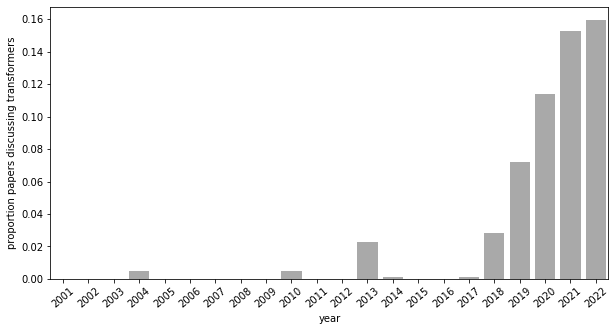

In [154]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.subplots(figsize=(10,5))
sns.barplot(data=prop_abstract[prop_abstract['year']>2000],
            x='year', 
            y='is_transformer_abstract_prop', color='darkgrey')
plt.xticks(rotation=40)
plt.ylabel('proportion papers discussing transformers')
plt.show()